In [533]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy


**Data Preparation**

In [534]:
dataset_temp, dataset_info = tfds.load("mnist", split=["train+test"], shuffle_files=True, as_supervised=True, with_info=True)

In [535]:
dataset_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/cheesemac/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [536]:
len(dataset_temp[0])

70000

In [537]:
dataset = dataset_temp[0]
VAL_TEST_RATIO = 0.1
TRAIN_RATIO = 1 - VAL_TEST_RATIO*2
DATASET_SIZE = len(dataset)

train_dataset = dataset.take(int(DATASET_SIZE*TRAIN_RATIO))

val_dataset = dataset.skip(int(DATASET_SIZE*TRAIN_RATIO))
val_dataset = val_dataset.take(int(DATASET_SIZE*VAL_TEST_RATIO))

test_dataset = dataset.skip(int(DATASET_SIZE*(TRAIN_RATIO+VAL_TEST_RATIO)))

print(len(test_dataset))
print(len(val_dataset))
print(len(train_dataset))

7000
7000
56000


In [538]:
list(test_dataset.take(1))

[(<tf.Tensor: shape=(28, 28, 1), dtype=uint8, numpy=
  array([[[  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0]],
  
         [[  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
        

**Data Visualization**

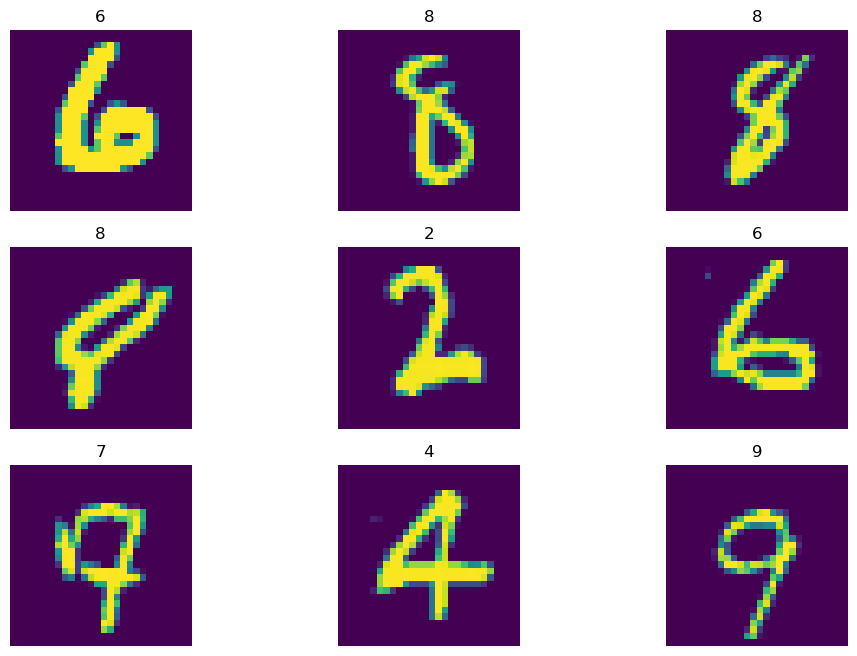

In [539]:
plt.figure(figsize=(12,8))
for i, (img, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label.numpy())
    plt.axis("off")

plt.show();

**Data Processing**

In [540]:
def normalize_image(img, label):
    return img/255, label

In [541]:
train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

In [542]:
BUFFER_SIZE = 300
BATCH_SIZE = 250
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

**Modelling**

In [543]:
IMG_SIZE = 28

Here we will use sigmoid activation, since the images are black and white

In [544]:
relu_model = Sequential([
    InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 1)),

    Conv2D(filters=64, kernel_size=3, padding="same", activation = "relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=32, kernel_size=3, padding="valid", activation = "relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),


    Flatten(),

    Dense(300, activation = "relu"),
    BatchNormalization(),

    Dense(84, activation = "relu"),
    BatchNormalization(),

    Dense(1, activation = "softmax")
])

relu_model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_137 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_268 (B  (None, 28, 28, 64)        256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_135 (MaxPool  (None, 14, 14, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_138 (Conv2D)         (None, 12, 12, 32)        18464     
                                                                 
 batch_normalization_269 (B  (None, 12, 12, 32)        128       
 atchNormalization)                                              
                                                     

In [545]:
relu_model.compile(optimizer=Adam(learning_rate=0.5),
                             loss = CategoricalCrossentropy(from_logits=True),
                             metrics = "accuracy")

In [546]:
process = relu_model.fit(train_dataset,validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20


2024-01-31 00:49:36.584464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


223/224 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1124

2024-01-31 00:49:43.231460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


224/224 [==============================] - 8s 30ms/step - loss: 0.0000e+00 - accuracy: 0.1124 - val_loss: 0.0000e+00 - val_accuracy: 0.1123
Epoch 2/20
224/224 [==============================] - 7s 31ms/step - loss: 0.0000e+00 - accuracy: 0.1124 - val_loss: 0.0000e+00 - val_accuracy: 0.1123
Epoch 3/20
224/224 [==============================] - 7s 30ms/step - loss: 0.0000e+00 - accuracy: 0.1124 - val_loss: 0.0000e+00 - val_accuracy: 0.1123
Epoch 4/20
224/224 [==============================] - 7s 30ms/step - loss: 0.0000e+00 - accuracy: 0.1124 - val_loss: 0.0000e+00 - val_accuracy: 0.1123
Epoch 5/20
224/224 [==============================] - 7s 31ms/step - loss: 0.0000e+00 - accuracy: 0.1124 - val_loss: 0.0000e+00 - val_accuracy: 0.1123
Epoch 6/20
160/224 [====================>.........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.1132

KeyboardInterrupt: 

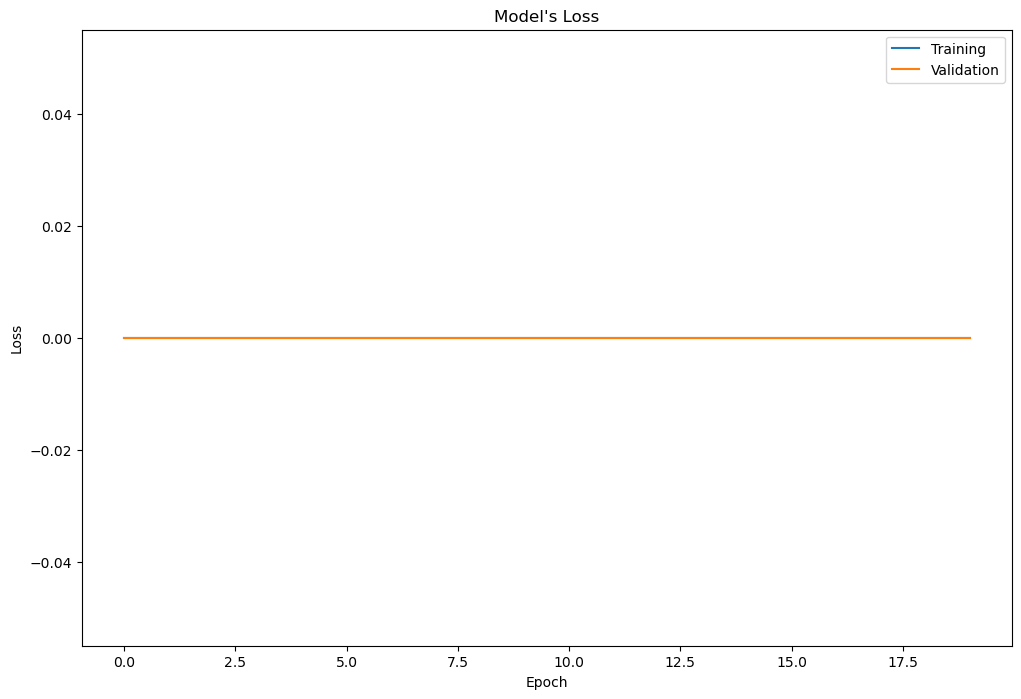

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(process.history["loss"])
plt.plot(process.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("Model's Loss")

plt.show();

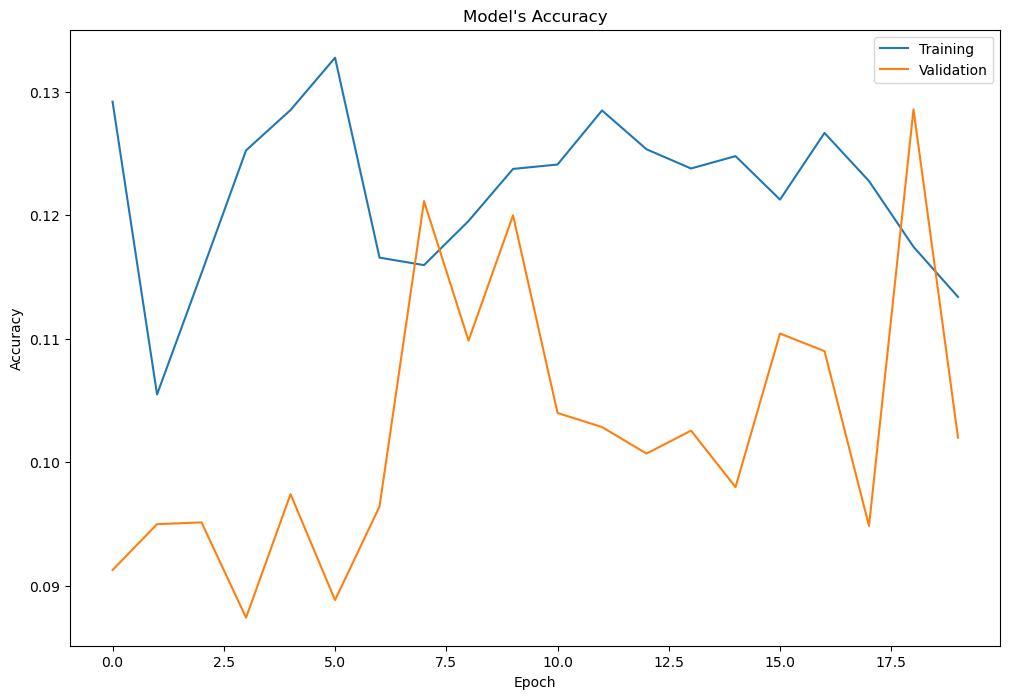

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(process.history["accuracy"])
plt.plot(process.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"])
plt.title("Model's Accuracy")

plt.show();